In [393]:
import numpy as np 

naca = np.loadtxt('naca0012.csv', skiprows=9, delimiter=',')[::3,:]/100.




In [394]:
import pygmsh

with pygmsh.occ.Geometry() as geom:
    outer = geom.add_disk([0.0, 0.0], 5.0, mesh_size=1.0)
    inner = geom.add_polygon(naca, mesh_size=0.1,
    )
    geom.boolean_difference(outer, inner)
    mesh = geom.generate_mesh()


nodes = mesh.points[:,:2]
alpha = 10.*np.pi/180.
nodes[:,0], nodes[:,1] = nodes[:,0]*np.cos(alpha) + nodes[:,1]*np.sin(alpha), nodes[:,1]*np.cos(alpha) - nodes[:,0]*np.sin(alpha)
elems = mesh.cells_dict['triangle']

/home/jakob/.local/lib/python3.8/site-packages/pygmsh/occ/geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean difference operation.
  warnings.warn(


In [395]:
# nodes = np.array([[-1., -1.],
#                   [2., -1.],
#                   [-2., 1.], 
#                   [1., 1.]])

# elems = np.array([[0, 1, 2], 
#                   [2, 1, 3]])

# n_x = 50
# x = np.linspace(-1.,1.,n_x+1)
# y = np.array([-1./n_x, 1./n_x])
# X, Y = np.meshgrid(x,y, indexing='ij')
# X = X.reshape((2*n_x + 2,))
# Y = Y.reshape((2*n_x + 2,))
# nodes = np.transpose(np.stack((X,Y)))

# elems = [[i+1, i, i+3, i+3, i, i+2] for i in range(0, 2*n_x, 2)]
# elems = np.array(elems).reshape(2*n_x, 3)

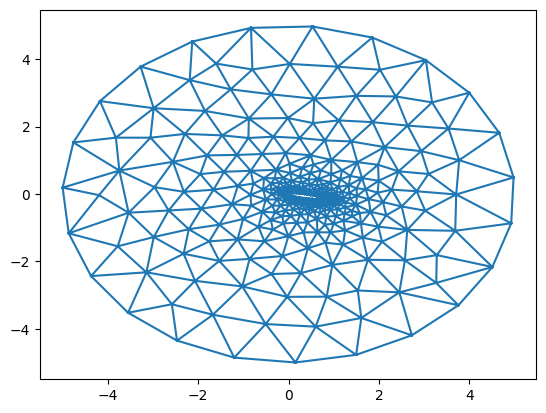

In [396]:
from matplotlib import pyplot as plt 

plt.figure() 
plt.triplot(nodes[:,0], nodes[:,1], elems)
plt.figure() 
plt.triplot(nodes[:,0], nodes[:,1], elems)
_ = plt.axis([-1.5, 1.5, -1., 1.])

In [397]:
# CONNECTIVITY
n_elems = elems.shape[0]
sides = np.concatenate((elems[:,:2], elems[:,1:], elems[:,::-2]))

sides, uniquesideids, elem2side_flat = np.unique(np.sort(sides), axis=0, return_index=True, return_inverse=True)
n_sides = sides.shape[0]
elem2side = np.transpose(np.reshape(elem2side_flat, (3, n_elems)))

# build side2elem
elem_ind = np.mod(np.arange(3*n_elems), n_elems)
sideid_2_elemid = np.transpose(np.stack((elem2side_flat, elem_ind)))
side2elem = np.zeros((n_sides, 2)).astype(int)-1
side2elem[sideid_2_elemid[uniquesideids,0],0] = sideid_2_elemid[uniquesideids,1]
sideid_2_elemid = np.delete(sideid_2_elemid, uniquesideids, axis=0)
side2elem[sideid_2_elemid[:,0],1] = sideid_2_elemid[:,1]

bcsides = np.argwhere(side2elem[:,1]<0)[:,0]
bc_wall = bcsides[np.linalg.norm(nodes[sides[bcsides,0],:], axis=1)<2.]
bc_outr = bcsides[np.linalg.norm(nodes[sides[bcsides,0],:], axis=1)>2.] 

In [398]:
# metrics 
volume = np.abs(np.cross(nodes[elems[:,1],:]-nodes[elems[:,0],:], nodes[elems[:,2],:]-nodes[elems[:,0],:], axis=1))/2.
diff = nodes[sides[:,1],:] - nodes[sides[:,0],:]
length = np.linalg.norm(diff, axis=1)
normal = np.stack((diff[:,1]/length , -diff[:,0]/length), axis = 1) 
barys = (nodes[elems[:,0],:] + nodes[elems[:,1],:] + nodes[elems[:,2],:])/3.
x_side = (nodes[sides[:,0],:] + nodes[sides[:,1],:]) / 2.
leftbary2side_vec = x_side - barys[side2elem[:,0],:]
is_wrong_direction = np.sum(leftbary2side_vec*normal, axis=1)  < 0.
normal[is_wrong_direction,:] *= -1.

# default: ourtward (-1)
outward_factor=np.zeros_like(elem2side) - 1
for iside in range(3):
    # inward are those where the elemID is second entry of side2elem
    outward_factor[side2elem[elem2side[:,iside],1] == np.arange(n_elems),iside] = 1. 

In [399]:
# initialize
DENS = 0
MOMX = 1
MOMY = 2 
ENER = 3
VELX = 1
VELY = 2
PRES = 3
FWD = 1
BWD = -1

# Mach 0.48
freeflow = np.zeros((1,4))
freeflow[:,DENS] = 1.
freeflow[:,MOMX] = 0.5
freeflow[:,MOMY] = 0.
freeflow[:,ENER] = 2. 

# def u_exact(x):
#     u_e = np.zeros((n_elems, 4))
#     u_e[...] = freeflow
#     u_e[np.abs(x[:,0])<0.2,DENS] = 1.1 + 0.1*np.cos(5*np.pi*x[np.abs(x[:,0])<0.2,0])
#     u_e[np.abs(x[:,0])<0.2,MOMX] = 1.1 + 0.1*np.cos(5*np.pi*x[np.abs(x[:,0])<0.2,0])
#     return u_e

u = np.zeros((n_elems, 4))
# u[:,:] = u_exact(barys)

u[:,:] = freeflow

u_left = np.zeros((n_sides, 4))
u_right = np.zeros((n_sides, 4))

u_right[bc_outr,:] = freeflow

In [400]:
from matplotlib import colormaps, colors, colorbar

def plot(u, title):
    umin, umax = np.min(u), np.max(u)
    umid = (umin+umax)/2.
    umin = np.minimum(umin, umid-0.01)
    umax = np.maximum(umax, umid+0.01)
    cnorm = colors.Normalize(umin, umax)
    # cnorm = colors.Normalize(0.99,1.01)
    cmap = colormaps.get_cmap('viridis')
    fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios': [10, 1]}) 
    for ielem in range(n_elems): 
        ax[0].fill(nodes[elems[ielem,:],0], nodes[elems[ielem,:],1], color = cmap(cnorm(u[ielem])))
    _ = ax[0].axis([-0.5, 1.5, -1., 1.])
    # _ = ax[0].axis([-1.5, 1.5, -2., 2.])
    cb1 = colorbar.ColorbarBase(ax[1], 
                                cmap=cmap,
                                norm=cnorm,
                                orientation='vertical')
    cb1.set_label(title)
    fig.suptitle(title)
    fig.show()

def plot_all():
    plot(u[:,DENS], 'Density')
    plot(u[:,MOMX], 'Momentum X')
    plot(u[:,MOMY], 'Momentum Y')
    plot(u[:,ENER], 'Energy')

In [401]:
import helpers
import copy

# rotate
def rotate(a, dir=FWD): 
    a[:,MOMX], a[:,MOMY] = a[:,MOMX]*normal[:,0] + dir*a[:,MOMY]*normal[:,1], a[:,MOMY]*normal[:,0] - dir*a[:,MOMX]*normal[:,1]

def fill_sides():
    # fill sides
    u_left[:,:] = u[side2elem[:,0],:]
    u_right[:,:] = u[side2elem[:,1],:]

    # fill BC sides 
    u_right[bc_outr,:] = freeflow

    rotate(u_left, dir=FWD)
    rotate(u_right, dir=FWD)

    u_right[bc_wall,:] = u_left[bc_wall,:] 
    u_right[bc_wall,MOMX] *= -1

    return u_left, u_right

# calculate flux 
def constoprim(u):
    up = copy.deepcopy(u)
    up[:,VELX] = u[:,MOMX] / u[:,DENS]
    up[:,VELY] = u[:,MOMY] / u[:,DENS]
    up[:,PRES] = 0.4*(u[:,ENER] - 0.5* u[:,DENS] * (up[:,VELX]**2 + up[:,VELY]**2) )
    return up


def flux(u, up):
    f = np.zeros_like(u)
    
    f[:,DENS] = up[:,VELX] * up[:,DENS]
    f[:,MOMX] = up[:,VELX]**2 * up[:,DENS] + up[:,PRES]
    f[:,MOMY] = up[:,VELX]*up[:,VELY]*up[:,DENS]
    f[:,ENER] = up[:,VELX]*( u[:,ENER] + up[:,PRES] )
    return f

def calc_flux(): 
    up_left = constoprim(u_left)
    up_right = constoprim(u_right)

    f_left = flux(u_left, up_left) 
    f_right = flux(u_right, up_right) 
    # f = 0.5 * (f_left + f_right) - helpers.stabilization_roe(u_left, up_left, u_right, up_right)

    a = np.maximum(lmbda(up_left), lmbda(up_right))
    f = 0.5 * (f_left + f_right) - 0.5 * a[...,np.newaxis] * (u_right-u_left)
    return f


def sos(up): 
    return np.sqrt(1.4*up[:,PRES]/up[:,DENS])


def lmbda(up): 
    return sos(up)+np.sqrt(up[:,VELX]**2+up[:,VELY]**2)

def timestep(up, dx): 
    return 0.99*dx/np.max(lmbda(up))

i=0
def change_of_state(f): 

    # rotate back
    rotate(f, dir=BWD)
    # print(f[:,MOMY])

    up = constoprim(u)
    if np.min(up[:,DENS])<0. or np.min(up[:,PRES])<0.:         
        plot_all() 
        raise Exception(f"Negative pressure or density encountered; timestep = {i}")
    time_step = timestep(up, 0.001)

    # add flux to cells 
    f = f * np.reshape(length,(n_sides,1))
    f_elem = np.zeros_like(u)
    for iside in range(3): 
        f_elem = f_elem + f[elem2side[:,iside],:] / np.reshape( volume * outward_factor[:,iside], (n_elems,1))
    return time_step * f_elem




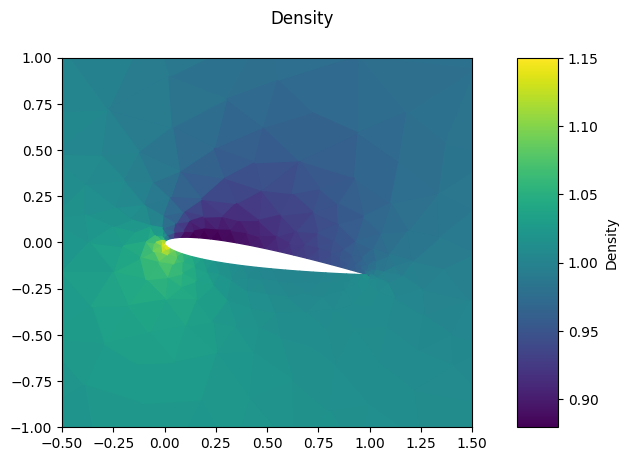

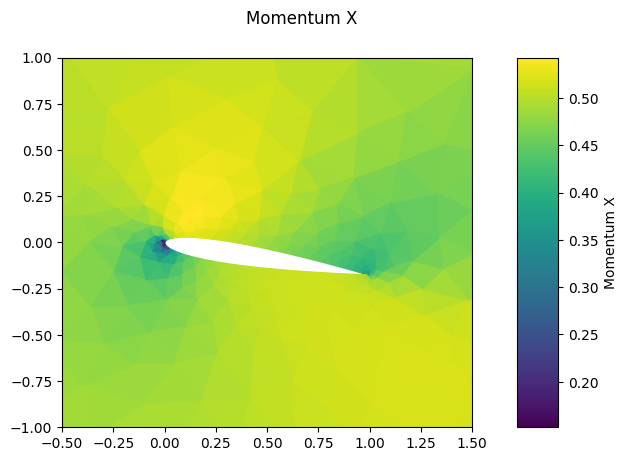

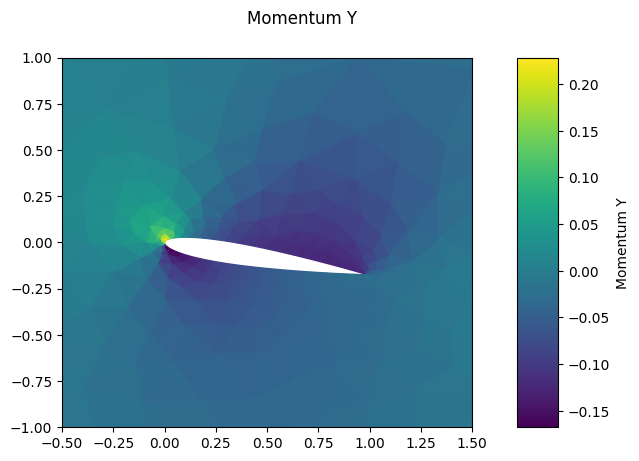

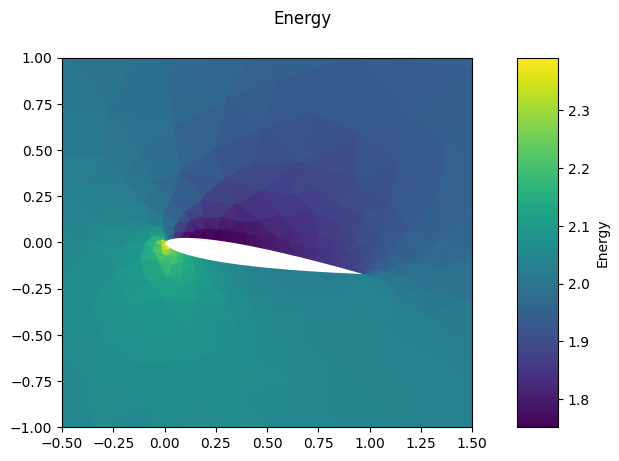

In [402]:

for i in range(3000): 
    u_left, u_right = fill_sides() 
    f = calc_flux()
    u = u + change_of_state(f)
plot_all()